### Urban Sound 8K Classification using RNN

This notebook implements audio classification using a Recurrent Neural Network (RNN), the intention being to exploit sequence patterns that occur in the feature inputs. This has been updated to use Python 3.

In [1]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 20, frames = 41):
    window_size = 512 * (frames - 1)
    mfccs = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            label = fn.split('fold')[1].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                    mfccs.append(mfcc)
                    labels.append(label)         
    features = np.asarray(mfccs).reshape(len(mfccs),bands,frames)
    return np.array(features), np.array(labels,dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

### Saving Extracted Features (optional)

The code in the cell below can be run (once) to convert the raw audio files into features, which are stored as numpy arrays. As this process is quite time consuming, we'd prefer to just do it once, and then load the numpy data when we want to do some training.


In [ ]:
# use this to process the audio files into numpy arrays
def save_folds(data_dir):
    for k in range(1,11):
        fold_name = 'fold' + str(k)
        print("\nSaving " + fold_name)
        features, labels = extract_features(parent_dir, [fold_name])
        labels = one_hot_encode(labels)
        
        print("Features of", fold_name , " = ", features.shape)
        print("Labels of", fold_name , " = ", labels.shape)
        
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        np.save(feature_file, features)
        print("Saved " + feature_file)
        np.save(labels_file, labels)
        print("Saved " + labels_file)

def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)
        
# uncomment this to recreate and save the feature vectors
# parent_dir = "UrbanSound8K/audio" # Where you have saved the UrbanSound8K data set"       
# save_dir = "data/us8k-np-rnn"
# assure_path_exists(save_dir)
# save_folds(save_dir)

### Reload

In [3]:
# this is used to load the folds incrementally
def load_folds(folds):
    subsequent_fold = False
    for k in range(len(folds)):
        fold_name = 'fold' + str(folds[k])
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        print (fold_name, "features: ", loaded_features.shape)

        if subsequent_fold:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            subsequent_fold = True
        
    return features, labels

This code below extracts the features from a single file - in this case, 88200 data points have been reduced to 5740. This is not as compact as the inputs fed into the Feed-Forward Network, which had only 193 features, but more compact than the 34440 features input into the CNN.

In [4]:
data_dir = "data/us8k-np-rnn"

def extract_feature_array(filename, bands = 20, frames = 41):
    window_size = 512 * (frames - 1)
    mfccs = []
    sound_clip,s = librosa.load(filename)
    for (start,end) in windows(sound_clip,window_size):
        if(len(sound_clip[start:end]) == window_size):
            signal = sound_clip[start:end]
            mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
            mfccs.append(mfcc)
            
    features = np.asarray(mfccs).reshape(len(mfccs),bands,frames)
    return np.array(features)

sample_filename = "samples/us8k/music.wav"
features = extract_feature_array(sample_filename)
data_points, _ = librosa.load(sample_filename)
print ("IN: Initial Data Points =", len(data_points))
print ("OUT: Total features =", np.shape(features))

IN: Initial Data Points = 88200
OUT: Total features = (7, 20, 41)


### Training a Recurrent Neural Network with Keras and TensorFlow

First, a method to define some metrics that will be used to evaluate the performance of a trained model.

In [5]:
tf.set_random_seed(0)
np.random.seed(0)

def evaluate(model):
    y_prob = model.predict_proba(test_x, verbose=0)
    y_pred = np_utils.probas_to_classes(y_prob)
    y_true = np.argmax(test_y, 1)

    roc = roc_auc_score(test_y, y_prob)
    print ("ROC:",  round(roc,3))

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
    print("\nAccuracy = {:.2f}".format(accuracy))

    # the F-score gives a similiar value to the accuracy score, but useful for cross-checking
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print ("F-Score:", round(f,2))
    
    return roc, accuracy

The following section defines the successive layers of our recurrent neural network (RNN). RNNs are effectively a series of feed-forward networks that are connected to each other. The output of each network, and its hidden layer is fed into the next one. 

LSTMs by default return the last vector, rather than the entire sequence, so the `return_sequences=True` flag is used to facilitate stacking, which allows for a more complex feature representation of the input, and thus a greater ability to generalise. A small dropout value is 

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

data_dim = 41
timesteps = 20
num_classes = 10

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()

# returns a sequence of vectors of dimension 256
model.add(LSTM(256, return_sequences=True, input_shape=(timesteps, data_dim)))  

model.add(Dropout(0.2))

# return a single vector of dimension 128
model.add(LSTM(128))  

model.add(Dropout(0.2))

# apply softmax to output
model.add(Dense(num_classes, activation='softmax'))


# compile the model for multi-class classification
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# load fold1 for testing
train_x, train_y = load_folds([1,2,3,4,5,6])

# load fold2 for validation
valid_x, valid_y = load_folds([9])
    
# load fold3 for testing
test_x, test_y = load_folds([10])

# a stopping function to stop training before we excessively overfit to the training set
earlystop = EarlyStopping(monitor='val_loss', patience=0, verbose=1, mode='auto')

model.fit(train_x, train_y, batch_size=128, nb_epoch=10, callbacks=[earlystop], validation_data=(valid_x, valid_y))


fold1 features:  (5446, 20, 41)
fold2 features:  (5388, 20, 41)
fold3 features:  (5852, 20, 41)
fold4 features:  (6048, 20, 41)
fold5 features:  (5689, 20, 41)
fold6 features:  (5080, 20, 41)
fold9 features:  (5118, 20, 41)
fold10 features:  (5218, 20, 41)
Train on 33503 samples, validate on 5118 samples
Epoch 1/10
33503/33503 [==============================] - 244s - loss: 1.0195 - acc: 0.6571 - val_loss: 1.9954 - val_acc: 0.4842

In [27]:
# now evaluate the trained model against the unseen test data
print("Evaluating model...")
roc, acc = evaluate(model)

Evaluating model...
ROC: 0.866
5216/5218 [============================>.] - ETA: 0s 

### Confusion Matrix


Showing Confusion Matrix


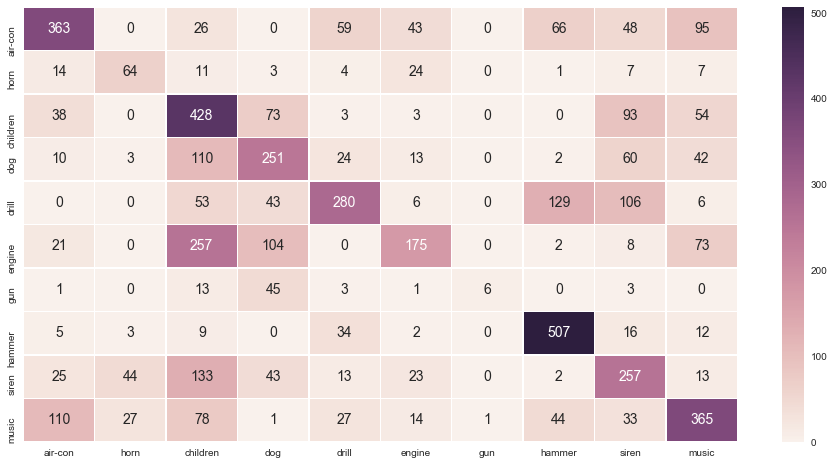

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

labels = ["air-con","horn","children","dog","drill","engine","gun","hammer","siren","music"]
print ("Showing Confusion Matrix")
y_prob = model.predict_proba(test_x, verbose=0)
y_pred = np_utils.probas_to_classes(y_prob)
y_true = np.argmax(test_y, 1)
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize = (16,8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5)

In [29]:
sound_file_paths = ["aircon.wav", "carhorn.wav", "play.wav", "dogbark.wav", "drill.wav",
                    "engine.wav","gunshots.wav","jackhammer.wav","siren.wav","music.wav"]
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
parent_dir = 'samples/us8k/'


# create predictions for each of the sound classes
for s in range(len(sound_names)):

    print ("\n----- ", sound_names[s], "-----")
    # load audio file and extract features
    predict_file = parent_dir + sound_file_paths[s]
    predict_x = extract_feature_array(predict_file)
    
    # generate prediction, passing in just a single row of features
    predictions = model.predict(predict_x)
    
    if len(predictions) == 0: 
        print ("No prediction")
        continue
    
    #for i in range(len(predictions[0])):
    #    print sound_names[i], "=", round(predictions[0,i] * 100, 1)
    
    # get the indices of the top 2 predictions, invert into descending order
    ind = np.argpartition(predictions[0], -2)[-2:]
    ind[np.argsort(predictions[0][ind])]
    ind = ind[::-1]
    
    print ("Top guess: ", sound_names[ind[0]], " (",round(predictions[0,ind[0]],3),")")
    print ("2nd guess: ", sound_names[ind[1]], " (",round(predictions[0,ind[1]],3),")")

    


-----  air conditioner -----
Top guess:  air conditioner  ( 0.955 )
2nd guess:  siren  ( 0.015 )

-----  car horn -----
Top guess:  car horn  ( 0.982 )
2nd guess:  street music  ( 0.012 )

-----  children playing -----
Top guess:  children playing  ( 0.512 )
2nd guess:  air conditioner  ( 0.233 )

-----  dog bark -----
Top guess:  dog bark  ( 0.79 )
2nd guess:  children playing  ( 0.168 )

-----  drilling -----
Top guess:  drilling  ( 0.978 )
2nd guess:  jackhammer  ( 0.012 )

-----  engine idling -----
Top guess:  engine idling  ( 0.984 )
2nd guess:  street music  ( 0.006 )

-----  gun shot -----
Top guess:  dog bark  ( 0.703 )
2nd guess:  gun shot  ( 0.215 )

-----  jackhammer -----
Top guess:  jackhammer  ( 0.72 )
2nd guess:  engine idling  ( 0.242 )

-----  siren -----
Top guess:  siren  ( 0.984 )
2nd guess:  dog bark  ( 0.014 )

-----  street music -----
Top guess:  street music  ( 0.642 )
2nd guess:  jackhammer  ( 0.165 )
